In [1]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

In [2]:
# Extract depth value at the center
center_depths_train = train_depths[:, 320, 240]
center_depths_val = val_depths[:, 320, 240]

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
center_depths_val = center_depths_val.reshape(-1, 1)

In [3]:
def divide_image(image):
    height, width, _ = image.shape
    mid_height, mid_width = height // 2, width // 2
    return [image[:mid_height, :mid_width, :], # Top left quadrant
            image[mid_height:, :mid_width, :], # Bottom left quadrant
            image[:mid_height, mid_width:, :], # Top right quadrant
            image[mid_height:, mid_width:, :]] # Bottom right quadrant

def calculate_center_depth(depth):
    height, width = depth.shape
    return depth[height // 2, width // 2]

# Divide validation images into quadrants and get center depths
val_quadrants = []
val_quad_depths = []
for i in range(val_images.shape[0]):
    quadrants = divide_image(val_images[i])
    depths = [calculate_center_depth(val_depths[i][j*val_depths.shape[1]//2:(j+1)*val_depths.shape[1]//2,
                                           k*val_depths.shape[2]//2:(k+1)*val_depths.shape[2]//2])
             for j in range(2) for k in range(2)]
    val_quadrants.extend(quadrants)
    val_quad_depths.extend(depths)

val_quadrants = np.array(val_quadrants)
val_quad_depths = np.array(val_quad_depths)


In [4]:
import tensorflow as tf

model = tf.keras.models.load_model('distance_prediction_fine_tuned.h5')

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Normalize and resize quadrants
val_quadrants = [cv2.resize(image / 255., (336, 448)) for image in val_quadrants]
val_quadrants = np.array(val_quadrants)

# Predict depths using the model
pred_depths = model.predict(val_quadrants).flatten()

# Calculate metrics
mae = mean_absolute_error(val_quad_depths, pred_depths)
mse = mean_squared_error(val_quad_depths, pred_depths)

print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

57/57 [==============================] - 14s 133ms/step
MAE: 1.0719
MSE: 2.2702


1/1 [==============================] - 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


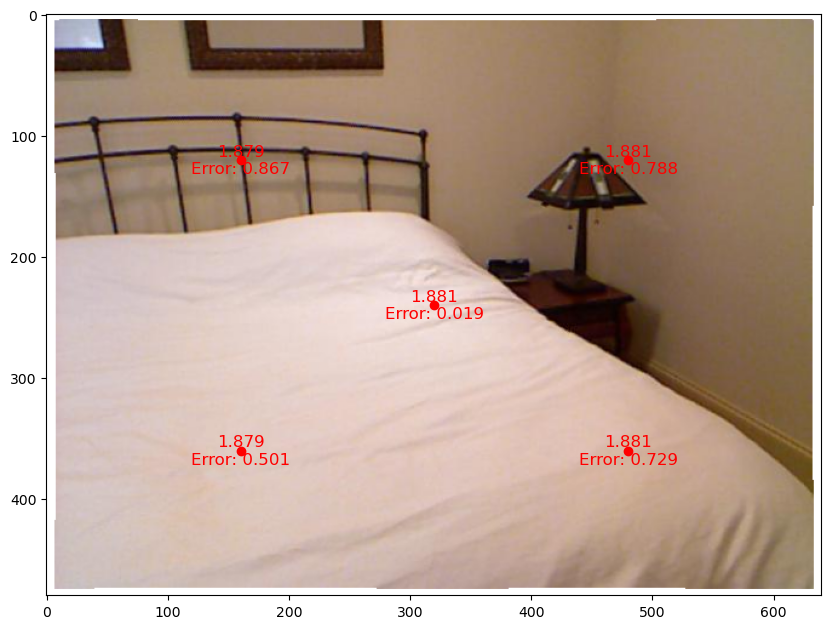

In [26]:
from scipy import ndimage

def predict_and_display(img, quadrants, true_depths, model):
    # Initialize an empty list to store the resized images
    resized_images = []

    # Resize each quadrant to the required shape and add to the list
    for quad in quadrants:
        resized_quad = cv2.resize(quad, (336, 448))
        resized_images.append(resized_quad)

    # Also resize the whole image and add it to the list
    resized_img = cv2.resize(img, (336, 448))
    resized_images.append(resized_img)

    # Convert the list to a numpy array and normalize the pixel values
    resized_images = np.array(resized_images, dtype=np.float32) / 255.0

    # Use the model to make predictions for the images
    predictions = model.predict(resized_images)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img)
    h, w = img.shape[:2]
    for i in range(5):
        depth_pred = predictions[i][0]  # Get the first (and only) value of the prediction
        true_depth = true_depths[i]
        error = abs(depth_pred - true_depth)
        if i == 0:  # Top left quadrant
            plt.text(w//4, h//4, f"{depth_pred:.3f}\nError: {error:.3f}", color='red', fontsize=12, ha='center', va='center')
            plt.plot(w//4, h//4, 'ro')
        elif i == 1:  # Bottom left quadrant
            plt.text(w//4, 3*h//4, f"{depth_pred:.3f}\nError: {error:.3f}", color='red', fontsize=12, ha='center', va='center')
            plt.plot(w//4, 3*h//4, 'ro')
        elif i == 2:  # Top right quadrant
            plt.text(3*w//4, h//4, f"{depth_pred:.3f}\nError: {error:.3f}", color='red', fontsize=12, ha='center', va='center')
            plt.plot(3*w//4, h//4, 'ro')
        elif i == 3:  # Bottom right quadrant
            plt.text(3*w//4, 3*h//4, f"{depth_pred:.3f}\nError: {error:.3f}", color='red', fontsize=12, ha='center', va='center')
            plt.plot(3*w//4, 3*h//4, 'ro')
        else:  # Center point
            plt.text(w // 2, h // 2, f"{depth_pred:.3f}\nError: {error:.3f}", color='red', fontsize=12, ha='center', va='center')
            plt.plot(w // 2, h // 2, 'ro')

    plt.show()

# Generate quadrants for an image
image_index = 0  # index of the image you want to display
img = val_images[image_index]
img = ndimage.rotate(img, angle=270)
img_quadrants = np.array(divide_image(img))

# Generate corresponding depth values
depth = val_depths[image_index]
quad_depths = [calculate_center_depth(depth[j*depth.shape[0]//2:(j+1)*depth.shape[0]//2,
                                           k*depth.shape[1]//2:(k+1)*depth.shape[1]//2])
             for j in range(2) for k in range(2)]
quad_depths.append(calculate_center_depth(depth))

# Display image with predictions
predict_and_display(img, img_quadrants, quad_depths, model)